![alt text](https://www.insa-lyon.fr/sites/www.insa-lyon.fr/files/logo-coul.png)



# Mask R-CNN - Camus Dataset
This notebook shows how to train, test and evaluate Mask R-CNN on [CAMUS dataset](https://www.creatis.insa-lyon.fr/Challenge/camus/).
- We note that we use a variation of this dataset where we have 3 binary masks instead of one mask with the 3 classes. This notebook is for the Lite version including only one class out of the three namely the `left ventiricule`.  
- We note that *train* section can be skipped if one wants to perform detection, evaluation... However, cells below the *detect* section are dependent of it.

Summary :
* I.   [Dataset](#dataset)
* II.  [Train](#train)
* III. [Detect](#detect)
* IV.  [Save output masks original format](#save)
* V.  [Inspect detection](#inspect)
* VI.   [Evaluate](#evaluate)

In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa
import tensorflow as tf
from keras import backend as k
from medpy import metric


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


# Configuration


In [2]:
class CamusConfig(Config):
    #Inherit the general config and change according for CAMUS
    
    NAME = "Camus"

    # We use a GPU with 12GB memory, which can fit 5 images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    
    # Batch size equivalent
    IMAGES_PER_GPU = 5

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 segment

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1800

    # Skip detections with < 50% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_MAX_INSTANCES=1
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448
    
    # USE_MINI_MASK = True
    # MINI_MASK_SHAPE = (56, 56) 
    
class CamusInferenceConfig(CamusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES=1
    # Don't resize imager for inferencing

    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MIN_CONFIDENCE = 0.5
    USE_MINI_MASK = False
    
config = CamusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

<a id='dataset'></a>

# I. Dataset

Load Camus dataset.

Override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
DEBUG=False

# Inherit from the general dataset class and overide/add some methods
class CamusDataset(utils.Dataset):
    
    def load_camus_images(self, dataset_dir,subset,test=0):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train, val or test
        """
        
        # Add classes. We have 1 classe and background is initialized per default
        self.add_class("camus", 1, "left ventricule")
        
        assert subset in ["train", "validation", "test"]
        if subset=="train":
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
        elif subset=="test":
            dataset_dir = os.path.join(dataset_dir, "test")
        else:
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
            
        #Path to mhd images (not gt)
        image_ids = []
        
        # r = root, d = directories, f = files
        for r, d, f in os.walk(dataset_dir):
            for file in f:    
                if ('ED.mhd' in file) or ('ES.mhd' in file):
                    image_ids.append(os.path.join(r, file))
        numImages=len(image_ids)
        
        # choose 1600 for train and 200 for validation
        train_limit = 1600
        
        if subset == "train":
            for image_id in image_ids[:train_limit]:                
                self.add_image(
                    "camus",
                    # image_id attribute is for debug only,:-4 to remove ".mhd"
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)
        elif subset == "validation":
            #print(image_ids[stopCount:])
            for image_id in image_ids[train_limit:]:                
                self.add_image(
                    "camus",
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)
        else:
            for image_id in image_ids:   
                self.add_image(
                    "camus",
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)
            
    def load_mask(self, image_id):
        """Load the corresponding mask to the image
        whose number is 'image_id' in the list 'image_ids'"""
        
        # Here image_id is a number that defines the element to choose from the list and not a path, 
        info = self.image_info[image_id]
        
        # Read the full path and remove .mhd and add _gt1.mhd to read corresponding gt mask
        mask1_dir = (info['path'][:-4]+"_gt1.mhd")
        mask1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_dir, sitk.sitkFloat32))
        
        if DEBUG:
            print(dataset_dir)
            print("mask direction"+str(mask1_dir))
            print("path"+str(info['path']))
            print("info"+str(info['id']))
            print("shape"+str(mask1.shape))
            
        # Mask needs to be of dimension 3
        mask1 = np.expand_dims(mask1, axis = 2)
        # Return the mask and an array to classify each binary mask. In this case, a scalar of value 1
        return mask1, np.arange(1,2, dtype = np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image. DEBUG ONLY"""
        
        info = self.image_info[image_id]
        if info["source"] == "camus":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        """Load the image and stack it for 3 channels RGB"""
        
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))
        # 2D grayscale image
        image = image[0,:,:]
        # Stack along th third axe to create a 3 channels image 
        image = np.stack((image,image,image),axis = 2)
        return image

## Load the different datasets
Load datasets and prepare data augmentation for the train dataset.


In [4]:
# Training dataset.
dataset_dir = "/floyd/input/"
dataset_train = CamusDataset()
dataset_train.load_camus_images(dataset_dir,"train")
dataset_train.prepare()
    
# Validation dataset
dataset_val = CamusDataset()
dataset_val.load_camus_images(dataset_dir, "validation")
dataset_val.prepare()

dataset_test = CamusDataset()
dataset_test.load_camus_images(dataset_dir, "test")
dataset_test.prepare()

# Specify which dataset to use next for visualization and evaluation   
dataset = dataset_test

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

# Prepare augmentation for training with imgaug
augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])
if DEBUG:
    image_id = 0
    print(dataset_train.image_ids.shape)
    im = dataset_train.load_image(image_id)
    print("image shape:"+str(im.shape))
    m,c = dataset_train.load_mask(image_id)
    print("mask shape:"+str(m.shape))

Image Count: 200
Class Count: 2
  0. BG                                                
  1. left ventricule                                   


<a id='train'></a>

# II. Train
## Create train Model and Inspect data
We create here the model for training and we inspect 4 random images of the datasets with their respective groundtruth.

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

81


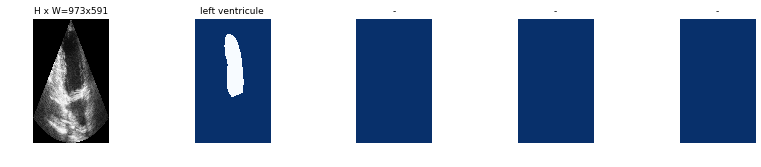

33


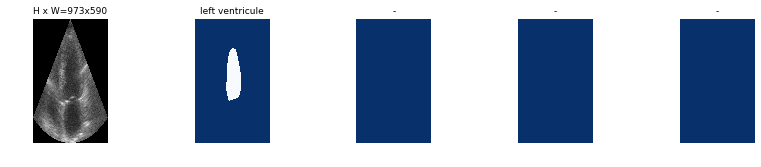

149


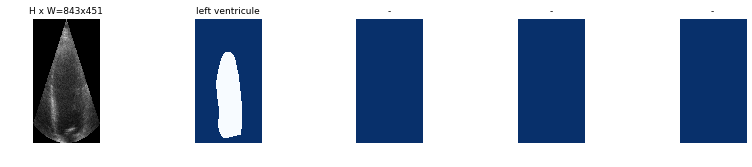

182


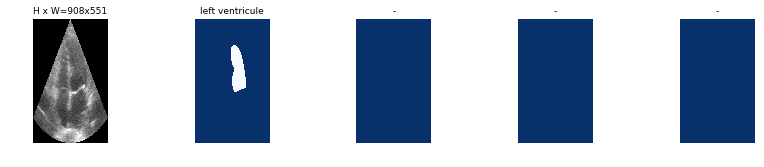

In [5]:
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    # Once again, image_id is a number and not the path
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Choose weights

In [ ]:
# Which weights to start with ?
# imagenet, coco, last or custom
init_with = "custom"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = "/floyd/home/logs/CAMUSLITE/mask_rcnn_camus_0031.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Pass `layers="all"` to train all layers.

In [14]:
# Skip warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model.train(dataset_train, dataset_val,
                    learning_rate = config.LEARNING_RATE,
                    epochs = 5,
                    layers = 'heads')

In [ ]:
'''
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
'''
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate = config.LEARNING_RATE,
            epochs = 15,
            layers = '4+')

In [ ]:
# Training - Stage 3 
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs = 32,#160
            layers = 'all')

<a id='detect'></a>

# III. Detect
We load the model for inference and we choose the weights, we then display the results and the groundtruth.

In [5]:
def detect (model, image_path=None):
    
    # Run model detection 
    print("Running on {}".format(args.image))
    # Read image
    image = sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkFloat32))
    # Detect and segment objects
    r = model.detect([image], verbose=1)[0]
    return r;

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
infConf = CamusInferenceConfig()
infConf.display()

model = modellib.MaskRCNN(mode = "inference", 
                          config = infConf,
                          model_dir = MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

init_with = "custom"  # imagenet, coco, or last or custom

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = "/floyd/home/logs/CAMUSLITE/mask_rcnn_camus_0031.h5"
    # model_path = "/floyd/home/mask_rcnn_camus_0039.h5"
    
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

## Segmentation Masks : Groundtruth *VS* Detection
The 2 following cells are for the resized masks.

original_image           shape: (448, 448, 3)         min:    0.00000  max:  230.91328  float32
image_meta               shape: (14,)                 min:    0.00000  max:  714.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  143.00000  max:  339.00000  int32
gt_mask                  shape: (448, 448, 1)         min:    0.00000  max:    1.00000  float32


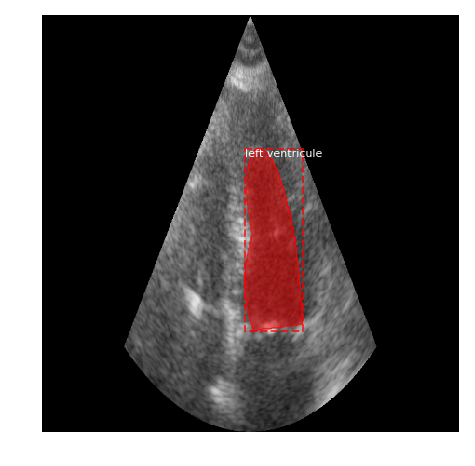

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  230.91328  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  127.01328  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32
original_image           shape: (448, 448, 3)         min:    0.00000  max:  230.91328  float32
detect_class_id          shape: (1,)                  min:    1.00000  max:    1.00000  int32
detect_bbox              shape: (1, 4)                min:  129.00000  max:  349.00000  int32
detect_mask              shape: (448, 448, 1)         min:    0.00000  max:    1.00000  bool


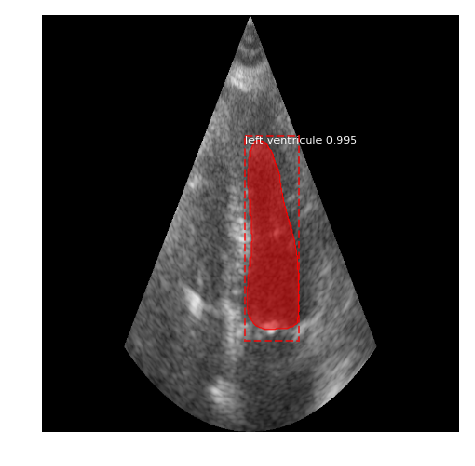

In [7]:
with tf.device("/gpu:0"):
    # Choose a random image from the dataset.
    image_id = np.random.choice(dataset.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, infConf, 
                               image_id, use_mini_mask=False)

    from mrcnn.model import log
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    
    # Display the gt mask
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    # Display the detected mask and confidence
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())
    log("original_image", original_image)
    log("detect_class_id", r['class_ids'])
    log("detect_bbox", r['rois'])
    log("detect_mask", r['masks'])

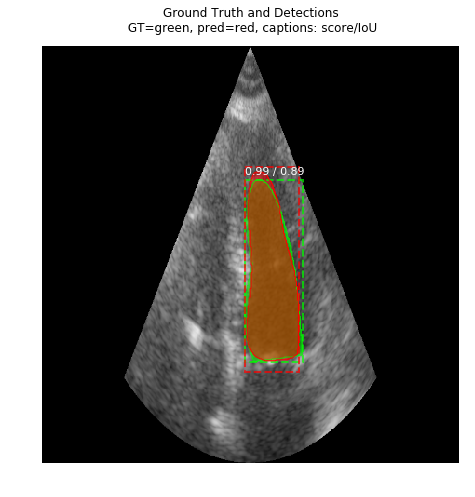

In [8]:
# Display the differences 
visualize.display_differences(original_image,gt_bbox,gt_class_id,gt_mask, r['rois'], r['class_ids'],r['scores'], r['masks'],
                            dataset.class_names, ax=get_ax())

The 2 following cells are for the masks with original size.

original_image           shape: (1168, 708, 3)        min:    0.00000  max:  255.00000  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_mask                  shape: (1168, 708, 1)        min:    0.00000  max:    1.00000  float32
gt_bbox                  shape: (1, 4)                min:  201.00000  max:  719.00000  int32


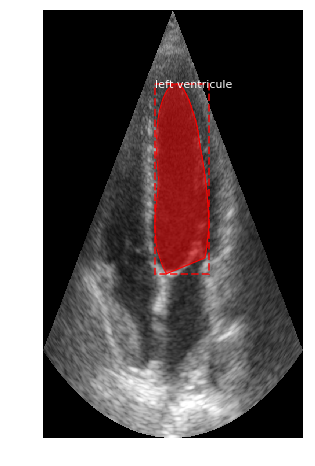

Processing 1 images
image                    shape: (1168, 708, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1168.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32
original_image           shape: (1168, 708, 3)        min:    0.00000  max:  255.00000  float32
detect_class_id          shape: (1,)                  min:    1.00000  max:    1.00000  int32
detect_bbox              shape: (1, 4)                min:  177.00000  max:  711.00000  int32
detect_mask              shape: (1168, 708, 1)        min:    0.00000  max:    1.00000  bool


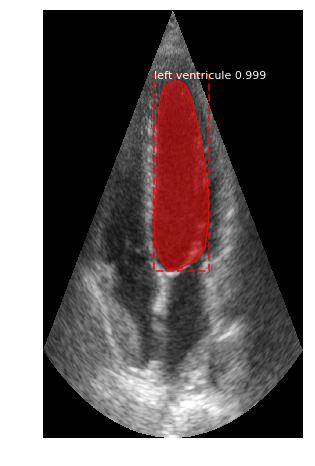

In [9]:
with tf.device("/gpu:0"):
    # Choose a random image from the dataset.
    image_id = np.random.choice(dataset.image_ids)
    original_image = dataset.load_image(image_id)
    gt_mask,gt_class_id = dataset.load_mask(image_id)
    gt_bbox = utils.extract_bboxes(gt_mask)
    
    from mrcnn.model import log
    log("original_image", original_image)
    log("gt_class_id", gt_class_id)
    log("gt_mask", gt_mask)
    log("gt_bbox", gt_bbox)

    # Display the groundtruth mask
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    # Display the detected mask and confidence
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())
    log("original_image", original_image)
    log("detect_class_id", r['class_ids'])
    log("detect_bbox", r['rois'])
    log("detect_mask", r['masks'])

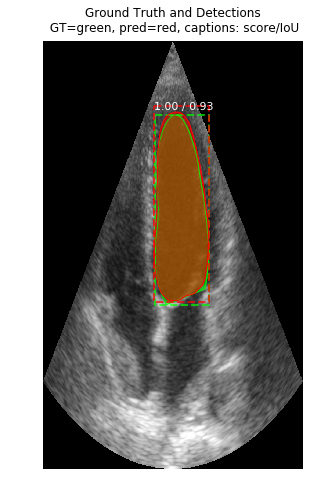

In [10]:
# Display the differences
visualize.display_differences(original_image,gt_bbox,gt_class_id,gt_mask, r['rois'], r['class_ids'],r['scores'], r['masks'],
                            dataset.class_names, ax=get_ax())

<a id='save'></a>
# IV. Saving output masks
This cell is used to save the detection masks in the original CAMUS format (not binaray masks).

In [ ]:
SavePath = '/floyd/home/results/'
image_ids = dataset.image_ids
#image_ids = np.random.choice(dataset.image_ids,1)

#Voxel spacing
spacing = [0.308,0.154,1.54]

# Fully print matrices/tensors
np.set_printoptions(threshold=sys.maxsize)

for image_id in image_ids:
   # Load image and ground truth data
    image = dataset.load_image(image_id)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Get the mask from the list
    result = r['masks'].astype('uint8')
    
    # -7 to get the patient number as a folder
    filename = SavePath + dataset.image_info[image_id]['id'][:-7] + '/' + dataset.image_info[image_id]['id'] + '.mhd'
    im = sitk.GetImageFromArray(result, isVector=False)
    im.SetSpacing(spacing)
    sitk.WriteImage(im,filename,False)

In [ ]:
# Check the saved output
image_ids = np.random.choice(dataset.image_ids,1)
filename = SavePath + dataset.image_info[image_id]['id'][:-7] + '/' + dataset.image_info[image_id]['id'] + '.mhd'
mask = sitk.GetArrayFromImage(sitk.ReadImage(filename, sitk.sitkFloat32))
print(mask.shape)
plt.imshow(mask[:,:,0])

<a id='inspect'></a>

# V. Inspect detection
Go through the detection process step by step.

In [41]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, infConf, image_id, use_mini_mask=False)
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (50127,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.48029  max:    2.70689  float64
positive_anchors         shape: (8, 4)                min:  114.74517  max:  261.25483  float64
negative_anchors         shape: (248, 4)              min: -128.00000  max:  466.62742  float64
neutral anchors          shape: (49871, 4)            min: -362.03867  max:  746.03867  float64
refined_anchors          shape: (8, 4)                min:  106.99999  max:  262.00000  float32


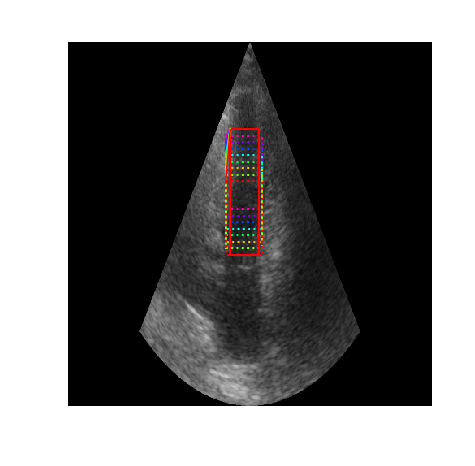

In [42]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [43]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 50127, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.80993  max:    1.66675  float32
refined_anchors          shape: (1, 6000, 4)          min: -280.59805  max:  282.59549  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (316,)                min:    0.00000  max: 5770.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


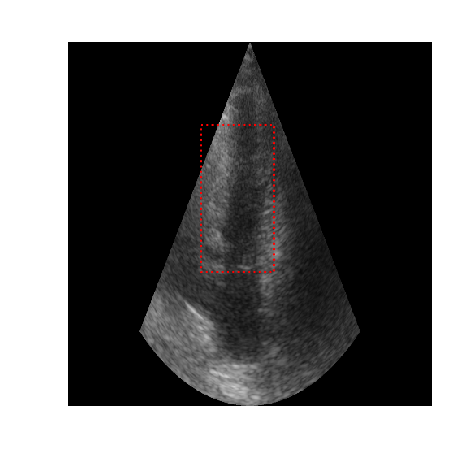

In [50]:
# Show top anchors by score (before refinement)
limit = 1
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

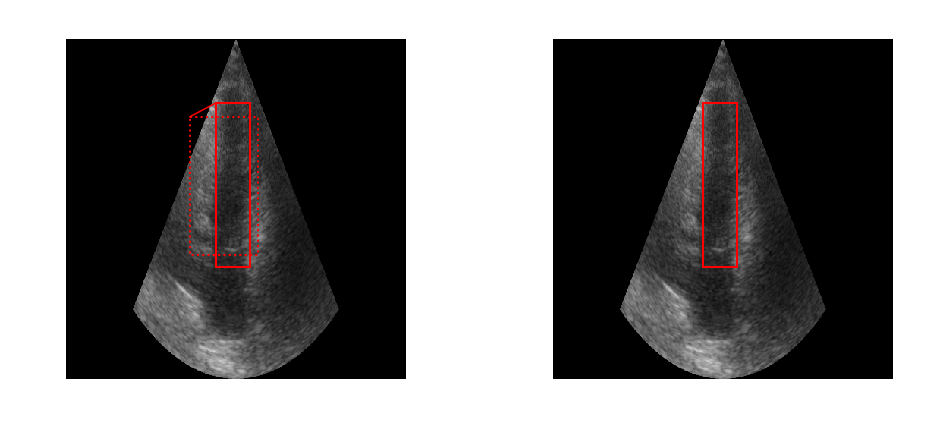

In [49]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 1
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

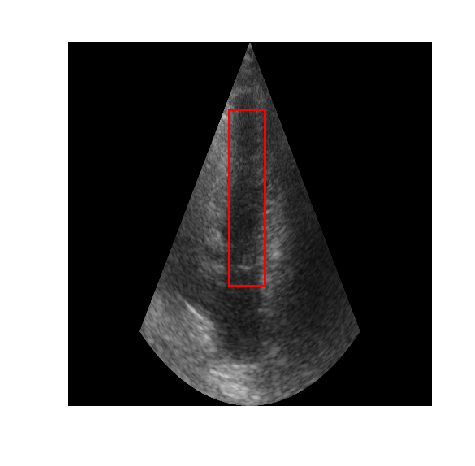

In [46]:
# Show refined anchors after non-max suppression
limit = 1
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

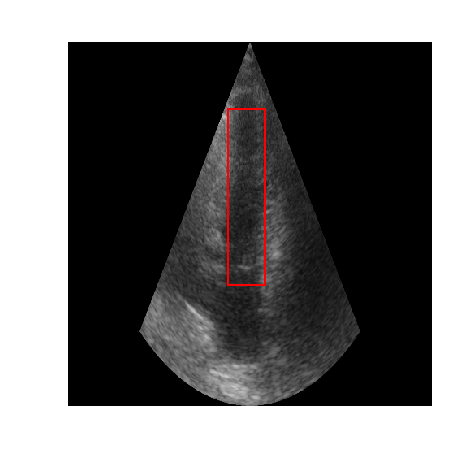

In [48]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 1
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

<a id='evaluate'></a>

# VI. EVALUATE
Evaluate the mAP, Dice, HD and ASD.
Best results so far :

| Dice          | HD (mm)       | ASSD (mm)  |
| ------------- | ------------- | ---------- |
| 0.92          | 5.89          | 1.85       |

In [3]:
missingMasks = 0
def dice (gt,detection):
    try:
        return metric.binary.dc (gt, detection)
    except:
        missingMasks = missingMasks + 1
        print ("Missing Mask")
        
def hd (gt, detection, voxel_spacing):
    try:
        return metric.binary.hd(gt, detection, voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
    except: 
        print ("Missing Mask")
        
def assd (gt, detection, voxel_spacing):
    try:
        return metric.binary.assd(gt, detection, voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
    except: 
        print ("Missing Mask")


Mean Dice:  0.9134237475026381  Std:  0.03490863380162258
Mean HD:  2.9038490550087066  Std:  1.2430206940051474
Mean ASD:  0.862547689335702  Std:  0.3940100093241418


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa66aa6358>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa66aa69e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa66aa6208>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa66aae0b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa66aae400>],
 'means': []}

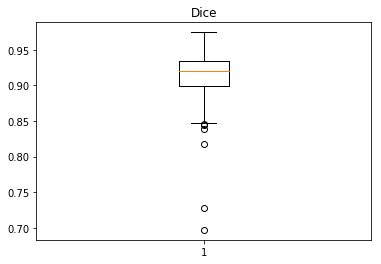

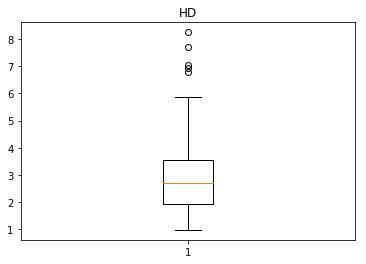

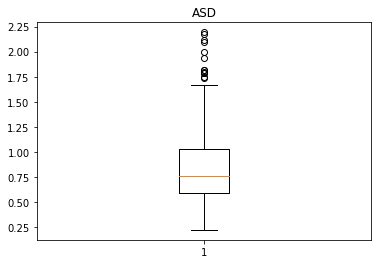

In [7]:
with tf.device("/gpu:0"):
    voxel_spacing = [0.308, 0.154]
    def dice(y_trueI, y_predI):
        try:

            """ Binary dice indice adapted to keras tensors """
            y_true=y_trueI.astype(float)
            y_pred=y_predI.astype(float)
            flat_y_true = k.flatten(y_true)
            flat_y_pred = k.flatten(y_pred)
            intersect = k.sum(flat_y_true * flat_y_pred)

            s_true = k.sum(flat_y_true)
            s_pred = k.sum(flat_y_pred)
            if DEBUG:
                print(flat_y_true)
                print(flat_y_pred)
                print(type(intersect))
                print(s_pred)
            res=tf.Session().run((2. * intersect + 1.) / (s_true + s_pred + 1.))
            return res
        except:
            print ("NO MASK !")
            return 0.0
    def hd (seg,gt):
        try:
            hdMask = metric.binary.hd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
            return hdMask
        except:
            return -1
    def asd (seg,gt):
        try:
            asdMask = metric.binary.assd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
            return asdMask
        except:
            return -1
         
    #***************************************************************************************************#
    
    #image_ids = np.random.choice(dataset_val.image_ids, 1)
    image_ids = dataset.image_ids
    APs = []
    DICEs = []
    HDs = []
    ASDs = []
    for image_id in image_ids:
   # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, infConf,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        #AP, precisions, recalls, overlaps =\
            #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
             #                r["rois"], r["class_ids"], r["scores"], r['masks'])
        #APs.append(AP)
    # Compute dice 
        DICEs.append(dice(gt_mask,r['masks']))
    # Compute hd
        HDs.append(hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
    # Compute asd
        ASDs.append(asd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
        #print(metric.binary.dc(r['masks'], gt_mask))  
        
        #print(r['masks'].squeeze(axis=2).shape)
        #print(metric.binary.hd(r['masks'], gt_mask,connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0], 1])) 
        #print(metric.binary.hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2),connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])) 
        
# print("mAP: ", np.mean(APs)," Std: ",np.std(APs))
# fig1, ax1 = plt.subplots()
# ax1.set_title('AP')
# ax1.boxplot(APs)
print("Mean Dice: ", np.mean(DICEs)," Std: ",np.std(DICEs))
fig2, ax2 = plt.subplots()
ax2.set_title('Dice')
ax2.boxplot(DICEs)
HDs=np.asarray(HDs)
ASDs=np.asarray(ASDs)
print("Mean HD: ", HDs[HDs>0].mean()," Std: ",np.std(HDs))
fig3, ax3 = plt.subplots()
ax3.set_title('HD')
ax3.boxplot(HDs)
print("Mean ASD: ", np.mean(ASDs[ASDs>0])," Std: ",np.std(ASDs))
fig4, ax4 = plt.subplots()
ax4.set_title('ASD')
ax4.boxplot(ASDs)

EVALUATION WTIHOUT RESIZE

Mean Dice:  0.9175191337786494  Std:  0.03335228053430202
Mean HD:  5.897260817568943  Std:  2.5075632054977346
Mean ASD:  1.8597408662627328  Std:  0.8309264582537751


{'whiskers': [<matplotlib.lines.Line2D at 0x7f3e1db5e400>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3e1db5ea90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3e1db5e2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3e1db65160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3e1db654a8>],
 'means': []}

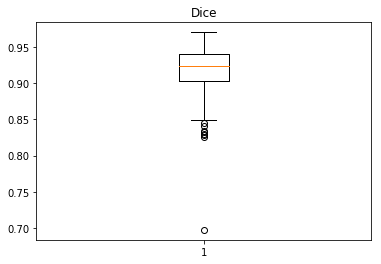

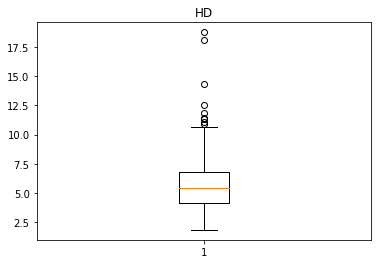

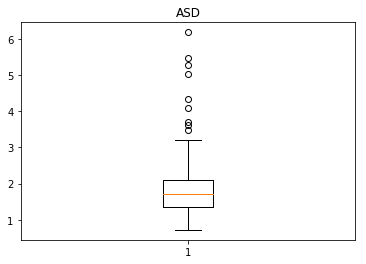

In [28]:
with tf.device("/gpu:0"):
    voxel_spacing = [0.308, 0.154]
    def dice(y_trueI, y_predI):
        try:

            """ Binary dice indice adapted to keras tensors """
            y_true=y_trueI.astype(float)
            y_pred=y_predI.astype(float)
            flat_y_true = k.flatten(y_true)
            flat_y_pred = k.flatten(y_pred)
            intersect = k.sum(flat_y_true * flat_y_pred)

            s_true = k.sum(flat_y_true)
            s_pred = k.sum(flat_y_pred)
            if DEBUG:
                print(flat_y_true)
                print(flat_y_pred)
                print(type(intersect))
                print(s_pred)
            res=tf.Session().run((2. * intersect + 1.) / (s_true + s_pred + 1.))
            return res
        except:
            print ("NO MASK !")
            return 0.0
    def hd (seg,gt):
        try:
            hdMask = metric.binary.hd(seg, gt,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
            return hdMask
        except:
            return -1
    def asd (seg,gt):
        try:
            asdMask = metric.binary.assd(seg, gt,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
            return asdMask
        except:
            return -1
         
    #***************************************************************************************************#
    image_ids = dataset.image_ids
    #image_id = np.random.choice(dataset.image_ids)
    APs = []
    DICEs = []
    HDs = []
    ASDs = []
    for image_id in image_ids:
   # Load image and ground truth data
            #image_ids = np.random.choice(dataset_val.image_ids, 1)
        
        image=dataset.load_image(image_id)
        gt_mask,gt_class_id=dataset.load_mask(image_id)
        gt_bbox = utils.extract_bboxes(gt_mask)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        #AP, precisions, recalls, overlaps =\
            #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
             #                r["rois"], r["class_ids"], r["scores"], r['masks'])
        #APs.append(AP)
    # Compute dice 
        DICEs.append(dice(gt_mask,r['masks']))
    # Compute hd, squeeze last dimension as it's unecessary
        HDs.append(hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
    # Compute asd
        ASDs.append(asd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
        #print(metric.binary.dc(r['masks'], gt_mask))  
        
        #print(r['masks'].squeeze(axis=2).shape)
        #print(metric.binary.hd(r['masks'], gt_mask,connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0], 1])) 
        #print(metric.binary.hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2),connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])) 
        
# print("mAP: ", np.mean(APs)," Std: ",np.std(APs))
# fig1, ax1 = plt.subplots()
# ax1.set_title('AP')
# ax1.boxplot(APs)
print("Mean Dice: ", np.mean(DICEs)," Std: ",np.std(DICEs))
fig2, ax2 = plt.subplots()
ax2.set_title('Dice')
ax2.boxplot(DICEs)
HDs=np.asarray(HDs)
ASDs=np.asarray(ASDs)
print("Mean HD: ", HDs[HDs>0].mean()," Std: ",np.std(HDs))
fig3, ax3 = plt.subplots()
ax3.set_title('HD')
ax3.boxplot(HDs)
print("Mean ASD: ", np.mean(ASDs[ASDs>0])," Std: ",np.std(ASDs))
fig4, ax4 = plt.subplots()
ax4.set_title('ASD')
ax4.boxplot(ASDs)


Evaluation : Mean Average Precision mAP

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
print("mAP: ", np.mean(APs)," Std: ",np.std(APs))
fig1, ax1 = plt.subplots()
ax1.set_title('AP')
ax1.boxplot(APs)
print(APs)

In [ ]:
from medpy import metric
import numpy as np

image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
def hd (seg,gt):
    try:
        hdMask = metric.binary.hd(seg, gt, connectivity=2)                   
        return hdMask
    except:
        return 0

HDs_mask = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute HD
    HD_mask = hd(r['masks'], gt_mask)
    #print("HD mask : ", HD_mask)
    HDs_mask.append(HD_mask)
    
print("HD mask: ", np.mean(HDs_mask), "std: ", np.std(HDs_mask))
fig2, ax2 = plt.subplots()
ax2.set_title('HD Plot')
ax2.boxplot(HDs_mask)

In [ ]:
from medpy import metric
import numpy as np

image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
def asd (seg,gt):
    try:
        asdMask = metric.binary.asd(seg, gt, connectivity=2)                   
        return asdMask
    except:
        return 0

asds_mask = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute asd
    asd_mask = asd(r['masks'], gt_mask)
    #print("HD mask : ", HD_mask)
    asds_mask.append(asd_mask)
    
print("Mean asd: ", np.mean(asds_mask), "std: ", np.std(asds_mask))
fig2, ax2 = plt.subplots()
ax2.set_title('ASD Plot')
ax2.boxplot(asds_mask)